In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import random
import sys
sys.path.append('../')
from modules import utils
import matplotlib.pyplot as plt
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Invalid MIT-MAGIC-COOKIE-1 key/home/lmuyama/anaconda3/envs/stable_baselines_tf2_env/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [2]:
SEED = 126
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

#### The data

In [3]:
# train_df = pd.read_csv('../data/train_set_basic.csv')
train_df = pd.read_csv('../new_data/knn_imputed/missingness_0.3.csv')
train_df = train_df.fillna(-1)
train_df.head()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,proteinuria,biopsy_proven_lupus_nephritis,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody,label
0,1.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.4,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.1,0.0,0.1,0.2,0.0,1.0,0.0,1
2,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.2,0.0,1.0,0.0,...,1.0,3.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1


In [4]:
val_df = pd.read_csv('../new_data/val_set_constant.csv')
val_df = val_df.fillna(-1)
val_df.head()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,proteinuria,biopsy_proven_lupus_nephritis,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df = pd.read_csv('../new_data/test_set_constant.csv')
test_df = test_df.fillna(-1)
test_df.head()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,proteinuria,biopsy_proven_lupus_nephritis,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody,label
0,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,4,1,0,0,0,1,0,0,1


In [6]:
X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_val = val_df.iloc[:, 0:-1]
y_val = val_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# X_train_scaled = scale_data(X_train)
# X_val_scaled = scale_data(X_val)
# X_test_scaled = scale_data(X_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50400, 24), (50400,), (5600, 24), (5600,), (14000, 24), (14000,))

In [7]:
train_df.label.value_counts()

0    25240
1    25160
Name: label, dtype: int64

In [8]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=3) 
y_val_onehot = keras.utils.to_categorical(y_val, num_classes=3) 
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=3) 
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((50400, 3), (5600, 3), (14000, 3))

#### The Model

In [9]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(24,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/ffnn/ffnn_checkpoint.h5', monitor='val_acc', save_best_only=True, save_weights_only=False
)

In [12]:
early_stopping = EarlyStopping(monitor='val_acc', patience=200)

In [13]:
history = model.fit(X_train, y_train_onehot, epochs=1000, batch_size=32, validation_data=(X_val, y_val_onehot), 
                    callbacks=[checkpoint, early_stopping])

Train on 50400 samples, validate on 5600 samples
Epoch 1/1000
 2720/50400 [>.............................] - ETA: 1s - loss: 0.6754 - acc: 0.7224  

2023-09-18 01:38:57.786455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-18 01:39:02.295262: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-18 01:39:02.295296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: PL1207-PRO.paris.inria.fr
2023-09-18 01:39:02.295299: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: PL1207-PRO.paris.inria.fr
2023-09-18 01:39:02.295432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-09-18 01:39:02.295455: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: Not found: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.125.06  Release Build  (

50400/50400 [==============================] - 1s 22us/sample - loss: 0.2953 - acc: 0.8633 - val_loss: 0.1377 - val_acc: 0.9725
Epoch 2/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.2616 - acc: 0.8740 - val_loss: 0.1334 - val_acc: 0.9766
Epoch 3/1000
50400/50400 [==============================] - 1s 21us/sample - loss: 0.2588 - acc: 0.8754 - val_loss: 0.1266 - val_acc: 0.9805
Epoch 4/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.2563 - acc: 0.8765 - val_loss: 0.1264 - val_acc: 0.9757
Epoch 5/1000
50400/50400 [==============================] - 1s 21us/sample - loss: 0.2536 - acc: 0.8760 - val_loss: 0.1195 - val_acc: 0.9766
Epoch 6/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.2503 - acc: 0.8771 - val_loss: 0.1126 - val_acc: 0.9846
Epoch 7/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.2481 - acc: 0.8779 - val_loss: 0.1063 - val_acc: 0.9837
Epoch 8/1000
50400/50400 [

Epoch 59/1000
50400/50400 [==============================] - 1s 21us/sample - loss: 0.1969 - acc: 0.9012 - val_loss: 0.0834 - val_acc: 0.9780
Epoch 60/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1965 - acc: 0.9019 - val_loss: 0.1030 - val_acc: 0.9666
Epoch 61/1000
50400/50400 [==============================] - 1s 21us/sample - loss: 0.1946 - acc: 0.9035 - val_loss: 0.1001 - val_acc: 0.9707
Epoch 62/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1944 - acc: 0.9027 - val_loss: 0.1040 - val_acc: 0.9714
Epoch 63/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1938 - acc: 0.9033 - val_loss: 0.1068 - val_acc: 0.9620
Epoch 64/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1932 - acc: 0.9036 - val_loss: 0.0949 - val_acc: 0.9743
Epoch 65/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1925 - acc: 0.9045 - val_loss: 0.1028 - val_acc: 0.9734
Epoch 

50400/50400 [==============================] - 1s 20us/sample - loss: 0.1680 - acc: 0.9200 - val_loss: 0.1419 - val_acc: 0.9605
Epoch 117/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1672 - acc: 0.9198 - val_loss: 0.1401 - val_acc: 0.9721
Epoch 118/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1685 - acc: 0.9196 - val_loss: 0.1454 - val_acc: 0.9711
Epoch 119/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1664 - acc: 0.9196 - val_loss: 0.1420 - val_acc: 0.9661
Epoch 120/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1670 - acc: 0.9201 - val_loss: 0.1468 - val_acc: 0.9659
Epoch 121/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1659 - acc: 0.9204 - val_loss: 0.1439 - val_acc: 0.9695
Epoch 122/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1654 - acc: 0.9206 - val_loss: 0.1514 - val_acc: 0.9666
Epoch 123/1000

50400/50400 [==============================] - 1s 20us/sample - loss: 0.1516 - acc: 0.9283 - val_loss: 0.2137 - val_acc: 0.9530
Epoch 174/1000
50400/50400 [==============================] - 1s 21us/sample - loss: 0.1520 - acc: 0.9275 - val_loss: 0.1981 - val_acc: 0.9670
Epoch 175/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1512 - acc: 0.9276 - val_loss: 0.1948 - val_acc: 0.9704
Epoch 176/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1502 - acc: 0.9286 - val_loss: 0.2025 - val_acc: 0.9698
Epoch 177/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1514 - acc: 0.9286 - val_loss: 0.2040 - val_acc: 0.9670
Epoch 178/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.1509 - acc: 0.9287 - val_loss: 0.2141 - val_acc: 0.9650
Epoch 179/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.1501 - acc: 0.9280 - val_loss: 0.1998 - val_acc: 0.9704
Epoch 180/1000

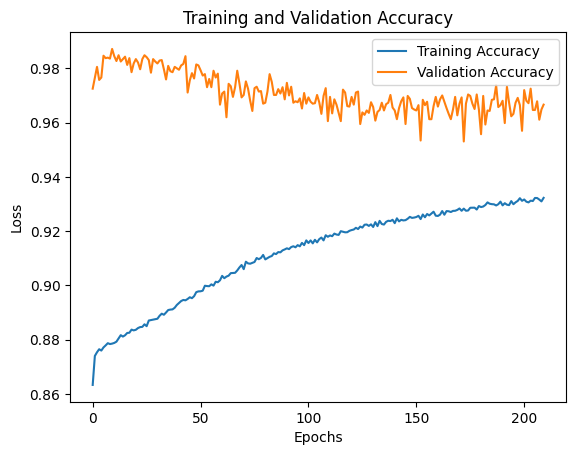

In [14]:
# Plot the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

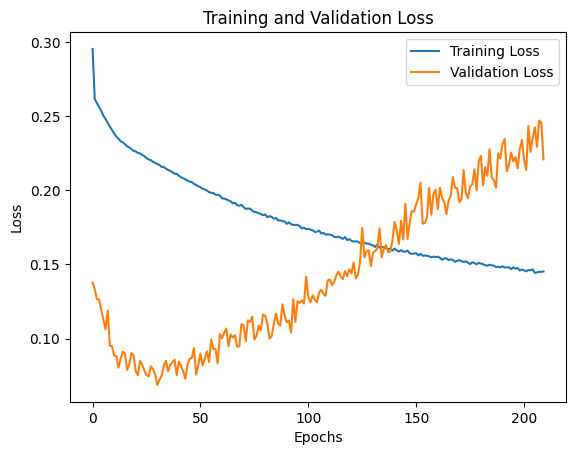

In [15]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Performance evaluation of the best model

In [16]:
best_model = keras.models.load_model('../models/ffnn/ffnn_checkpoint.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
loss, accuracy = best_model.evaluate(X_test, y_test_onehot)
loss, accuracy

14000/14000 [==============================] - 0s 10us/sample - loss: 0.0948 - acc: 0.9851


(0.09476308024914137, 0.9850714)

#### More metrics

In [18]:
model_predictions = best_model.predict(X_test)
y_pred = np.argmax(model_predictions, axis=1)

In [19]:
y_pred.shape, y_test.shape

((14000,), (14000,))

In [20]:
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [21]:
acc, f1, roc_auc = utils.test(y_test, y_pred)
acc, f1, roc_auc

(98.50714285714287, 98.5071419355315, 98.50750957976855)

In [22]:
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='macro')
# roc_auc = roc_auc_score(y_test_onehot, model_predictions, average='macro', multi_class='ovr')
# print(f'Accuracy: {accuracy}, F1: {f1}, ROC-AUC:{roc_auc}')

In [23]:
test_df = pd.DataFrame()
test_df['y_actual'] = y_test
test_df['y_pred'] = y_pred
acc, f1, roc_auc =  utils.test(test_df.y_actual, test_df.y_pred)
acc, f1, roc_auc

(98.50714285714287, 98.5071419355315, 98.50750957976855)

In [24]:
utils.test(y_test, test_df.y_pred)

(98.50714285714287, 98.5071419355315, 98.50750957976855)